In [1]:
!pip install --upgrade opencv-python

     |████████████████████████████████| 51.0MB 58kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [2]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15113, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 15113 (delta 15), reused 29 (delta 11), pack-reused 15073
Receiving objects: 100% (15113/15113), 13.46 MiB | 15.62 MiB/s, done.
Resolving deltas: 100% (10260/10260), done.


In [3]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile

#These lines make Yolo use gpu acceleration 

#!sed -i 's/GPU=0/GPU=1/' Makefile
#!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
#!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [4]:
#This command builds darknet so that we can use YOLOv4
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:935:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1136:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_opencv.cpp:1139:10: note: ...this statement, but the latter is misleadingly indent

In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# define helper functions
#This function replaces the built-in cv2 imshow with one that works with google colab
def imShow(image):
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [6]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

/content
Mounted at /content/gdrive
'Colab Notebooks'  'My Drive'  'S4 screenshots'   yolov4
 images		    OCR         videos		  yolov4_ocr


In [7]:
%cd darknet/

/content/darknet


In [8]:
#We copy the config file from the drive to config folder after modifition --Always use this command especially when not training
!cp /mydrive/yolov4/yolov4-obj.cfg ./cfg
!cp /mydrive/yolov4_ocr/yolov4-obj.cfg ./cfg/yolov4_ocr-obj.cfg

In [9]:
!pwd

/content/darknet


In [10]:
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-obj.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-obj.cfg
!sed -i 's/batch=64/batch=1/' yolov4_ocr-obj.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4_ocr-obj.cfg
%cd ..

/content/darknet/cfg
/content/darknet


In [11]:
%cd /content/

/content


In [12]:
import numpy as np
import math

In [13]:
#This neural network is the YoloV4 model that handles the plates extraction
net1 = cv2.dnn.readNetFromDarknet("/content/darknet/cfg/yolov4-obj.cfg","/mydrive/yolov4/backup/yolov4-obj_last.weights")

In [74]:
img = cv2.imread("/mydrive/images/img.jpg")
h,w = img.shape[:2]
ln = net1.getLayerNames()
ln = [ln[i[0]-1] for i in net1.getUnconnectedOutLayers()]

blob = cv2.dnn.blobFromImage(img,1/255.0,(416,416),swapRB=True, crop=False)
net1.setInput(blob)
layerOutputs = net1.forward(ln)

In [75]:
boxes = []
confidences = []

for output in layerOutputs:
  for detection in output:
    scores = detection[5:]
    classId = np.argmax(scores)
    confidence = scores[classId]
    if confidence > 0.3:
      box = detection[0:4]* np.array([w,h,w,h])
      centerX,centerY,width,height = box.astype("int")
      x = int (centerX-(width/2))
      y = int (centerY-(height/2))
      
      boxes.append([x,y,int (width),int (height)])
      confidences.append(float (confidence))

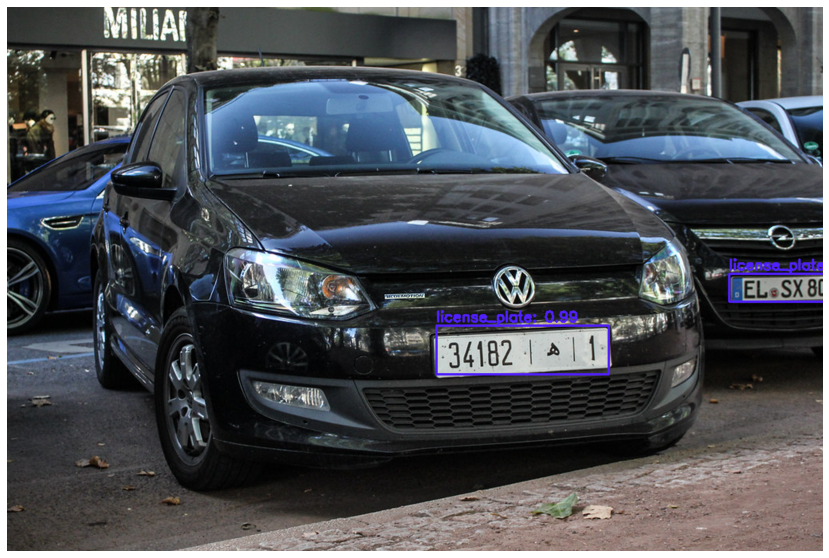

In [76]:
idxs = cv2.dnn.NMSBoxes(boxes,confidences,0.8,0.3)
n = len(idxs)
if n>0:
  for i in idxs.flatten():
    x,y = boxes[i][0],boxes[i][1]
    w,h = boxes[i][2],boxes[i][3]
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,32,80),2)
    text = "license_plate: {:.2f}".format(confidences[i])
    cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.6, (255,32,80), 2)
imShow(img)

In [77]:
#plate extraction 
plates = []
if n>0:
  for i in idxs.flatten():
    x,y,w,h = boxes[i][0],boxes[i][1],boxes[i][2],boxes[i][3]
    plate = img[y+2:y+h-1,x+2:x+w-1]
    plates.append(plate)
    

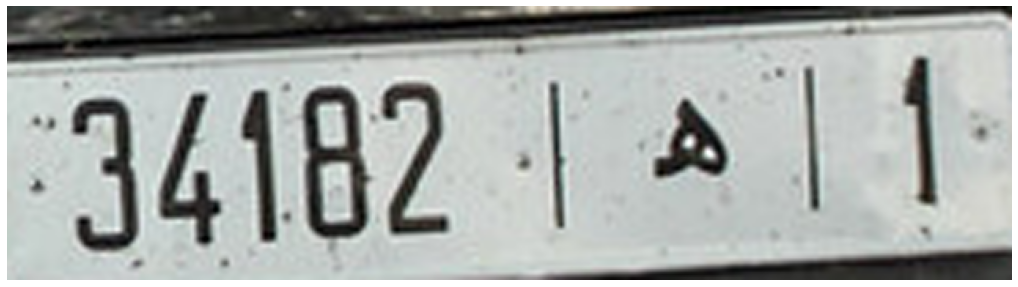

In [78]:
imShow(plates[0])

In [19]:
labels = ['0','1','2','3','4','5','6','7','8','9','a','b','waw','d','h','w','ch']

In [68]:
#This neural network is the YoloV4 model that handles the OCR part of the system
net2 = cv2.dnn.readNetFromDarknet("/content/darknet/cfg/yolov4_ocr-obj.cfg","/mydrive/yolov4_ocr/backup/yolov4-obj_last.weights")

In [79]:
img = plates[0].copy()
h,w = img.shape[:2]
ln = net2.getLayerNames()
ln = [ln[i[0]-1] for i in net2.getUnconnectedOutLayers()]

blob = cv2.dnn.blobFromImage(img,1/255.0,(416,416),swapRB=True, crop=False)
net2.setInput(blob)
layerOutputs = net2.forward(ln) 

In [80]:
boxes = []
confidences = []
classIDs = []

for output in layerOutputs:
  for detection in output:
    scores = detection[5:]
    classId = np.argmax(scores)
    confidence = scores[classId]
    if confidence > 0.3:
      box = detection[0:4]* np.array([w,h,w,h])
      centerX,centerY,width,height = box.astype("int")
      x = int (centerX-(width/2))
      y = int (centerY-(height/2))
      
      boxes.append([x,y,int (width),int (height)])
      confidences.append(float (confidence))
      classIDs.append(classId)

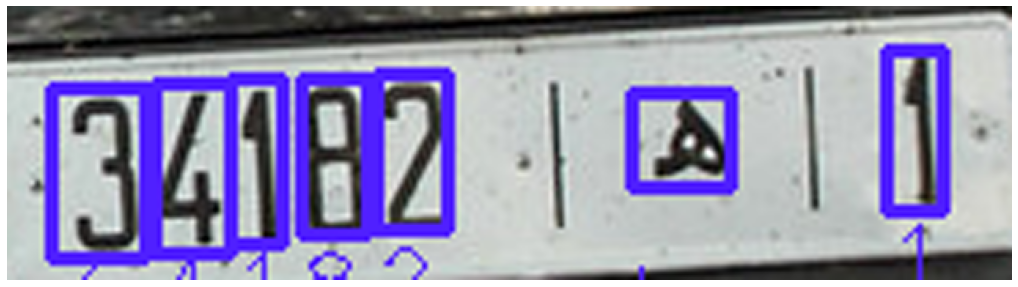

In [81]:
idxs = cv2.dnn.NMSBoxes(boxes,confidences,0.8,0.3)
n = len(idxs)
res = []
if n>0:
  for i in idxs.flatten():
    x,y = boxes[i][0],boxes[i][1]
    w,h = boxes[i][2],boxes[i][3]
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,32,80),2)
    confs = "{:.2f}".format(confidences[i])
    cla = "{}".format(labels[classIDs[i]])
    res.append((x,cla,confs))
    #cv2.putText(img, cla, (x, y + 70), cv2.FONT_HERSHEY_SIMPLEX,1, (69,100,130), 2)
    cv2.putText(img, cla, (x, y+50), cv2.FONT_HERSHEY_SIMPLEX,0.6, (255,32,80), 1)
imShow(img)

In [82]:
res.sort()
print(res)

[(9, '3', '0.98'), (31, '4', '0.99'), (47, '1', '0.95'), (62, '8', '0.99'), (78, '2', '1.00'), (132, 'h', '0.99'), (186, '1', '0.97')]


In [84]:
plateText = ""
for x in res :
  if x[1]=='a' :
    plateText += " أ\t"
  elif x[1]=='b':
    plateText += " ب\t"
  elif x[1]=='waw':
    plateText += " و\t"
  elif x[1]=='d':
    plateText += " د\t"
  elif x[1]=='h':
    plateText += " ه\t "
  elif x[1]=='ch':
    plateText += " ش\t "
  else :
    plateText += x[1]
print(plateText)

34182 ه	 1
